In [243]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt

from sklearn.metrics import *
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(0)
torch.manual_seed(0)

In [284]:
def compute_auc_mcc_f1(pred_paths, threshold):
    overall_pred = list()
    overall_true = list()
    overall_thres_pred = list()
    individual_auc = list()
    individual_mcc = list()
    individual_f1 = list()

    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        try:
            auc = roc_auc_score(true, pred)
            individual_auc.append(auc)
            fpr, tpr, _ = roc_curve(true, pred)

            thresh_pred = torch.zeros(len(pred))
            thresh_pred[pred >= threshold] = 1
            mcc = matthews_corrcoef(true, thresh_pred)
            individual_mcc.append(mcc)
            f1 = f1_score(true, thresh_pred)
            individual_f1.append(f1)
            
            overall_pred.extend(pred)
            overall_true.extend(true)
            overall_thres_pred.extend(thresh_pred)
        except ValueError:
            print(f"Fail for idx {i}")
            individual_auc.append(None)
            individual_mcc.append(None)
        
    overall_auc = roc_auc_score(overall_true, overall_pred)
    overall_fpr, overall_tpr, _ = roc_curve(overall_true, overall_pred, pos_label=1)
    overall_mcc = matthews_corrcoef(overall_true, overall_thres_pred)
    overall_f1 = f1_score(overall_true, overall_thres_pred)
    
    return overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc, overall_f1, individual_f1

def plot_roc_curve(unique_peptide, excluded, tpr, fpr, individual_auc):
    # ROC plot
    cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
    for i, pep in enumerate(unique_peptides):
        if pep not in excluded:
            ax.plot(
                fpr[i], 
                tpr[i], 
                label=f"{pep}, AUC = {round(individual_auc[i], 3)}",
            )
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    plt.show()

def plot_confusion_matrix(pred_paths, threshold, normalize=None):
    overall_true = list()
    overall_thres_pred = list()
    labels = ["non-binder", "binder"]
    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        thresh_pred = torch.zeros(len(pred))
        thresh_pred[pred >= threshold] = 1

        overall_true.extend(true)
        overall_thres_pred.extend(thresh_pred)
    
    cm = confusion_matrix(overall_true, overall_thres_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    plot = disp.plot()
    plot.figure_.show()
    
    #plt.legend()
    #plt.plot([0, 1], [0, 1], linestyle="--")
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    #plt.show()

In [172]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results_3"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [173]:
no_pos_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
for pep in no_pos_peptides:
    unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == pep))

threshold = 0.15
cv_fold = 5
excluded = []

### Embedding verification

In [6]:
save_dir = Path(out_dir / "lstm_embedding_verification/")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_pred = list()
overall_true = list()
for i in range(len(pred_paths)):
    data = torch.load(pred_paths[i], map_location="cpu")
    pred = data["y_pred"]
    true = data["y_true"]

    auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
    print(auc)
    overall_pred.extend(pred)
    overall_true.extend(true)
overall_auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
print(overall_auc)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sebastian/masters/data/results_3/lstm_embedding_verification/pred_0.pt'

### LOO validation

In [294]:
overall_LOO_results_df = pd.DataFrame(columns=[
    "Model",
    "Embedding",
    "Swapped negatives",
    "AUC",
    f"MCC (threshold = {threshold})",
    f"F1 (threshold = {threshold})"
])

individual_AUC_results_df = pd.DataFrame(columns=["Model", "Embedding", "Swapped negatives"] + list(unique_peptides))

individual_MCC_results_df = pd.DataFrame(columns=["Model", "Embedding", "Swapped negatives"] + list(unique_peptides))

individual_F1_results_df = pd.DataFrame(columns=["Model", "Embedding", "Swapped negatives"] + list(unique_peptides))

model_names = [
    ["Single LSTM", "PS (old)", 0],
    ["Single LSTM", "energy terms", 0],
    ["Single LSTM", "BLOSUM50", 0],
    ["Single LSTM", "PS", 0],
    ["Single LSTM", "ESM", 0],
    ["Single LSTM", "ESM+PS", 0],
    ["Quad LSTM", "energy terms", 1],
    ["Quad LSTM", "energy terms", 0],
    ["Quad LSTM", "BLOSUM50", 1],
    ["Quad LSTM", "BLOSUM50", 0],
    ["Quad LSTM", "PS", 1],
    ["Quad LSTM", "PS", 0],
    ["Quad LSTM", "ESM+PS", 1],
    ["Quad LSTM", "ESM+PS", 0],
    ["Quad LSTM", "ESM", 1],
    ["Quad LSTM", "ESM", 0],
    ["Quad LSTM", "PS (FoldX)", 0],
    ["Quad LSTM", "ESM+PS (FoldX)", 0],
    ["Quad LSTM", "PS (Rosetta)", 0],
    ["Quad LSTM", "ESM+PS (Rosetta)", 0],
    ["Quad LSTM", "PS (repaired model subset)", 1],
    ["Quad LSTM", "PS (repaired model subset)", 0],
    ["Quad LSTM", "ESM+PS (repaired model subset)", 0],
    ["Quad LSTM nested LOO", "PS", 1],
    ["Quad LSTM nested LOO", "ESM+PS", 1],
    ["Quad LSTM nested LOO", "ESM", 1],
    ["Quad LSTM", "PS nested LOO (FoldX)", 0],
    ["Quad LSTM", "PS nested LOO (Rosetta)", 0],
    ["Triple LSTM", "PS", 1],
    ["Triple LSTM", "PS", 0],
    ["Triple LSTM", "ESM+PS", 0],
    ["Triple LSTM", "ESM", 0],
    ["Triple LSTM", "PS (Rosetta)", 0],
    ["Triple LSTM", "ESM+PS (Rosetta)", 0],
    ["Triple LSTM", "PS (FoldX)", 0],
    ["Triple LSTM", "ESM+PS (FoldX)", 0],
    ["Triple LSTM", "energy terms", 0],
    ["Triple LSTM", "BLOSUM50", 0],
    ["Triple LSTM", "PS (repaired model subset)", 0],
    ["Modified ProteinSolver", "Raw", 1],
    ["Modified ProteinSolver", "Raw", 0],
    ["Modified ProteinSolver", "Raw (FoldX)", 0],
    ["Modified ProteinSolver", "Raw (Rosetta)", 0],
]

paths = [
    "lstm_ps_single_no_swapped",
    "single_lstm_energy_no_swapped",
    "single_lstm_blosum_no_swapped",
    "single_lstm_ps_no_swapped",
    "single_lstm_esm_no_swapped",
    "single_lstm_esm_ps_no_swapped",
    "lstm_energy",
    "lstm_energy_no_swapped",
    "lstm_blosum",
    "lstm_blosum_no_swapped",
    "lstm_ps",
    "lstm_ps_no_swapped",
    "lstm_esm_ps",
    "lstm_esm_ps_no_swapped",
    "lstm_esm",
    "lstm_esm_no_swapped",
    "lstm_ps_foldx_no_swapped",
    "lstm_esm_ps_foldx_no_swapped",
    "lstm_ps_rosetta_no_swapped/",
    "lstm_esm_ps_rosetta_no_swapped",
    "lstm_ps_repaired_model_subset",
    "lstm_ps_repaired_model_subset_no_swapped",
    "lstm_esm_ps_repaired_model_subset_no_swapped",
    "lstm_ps_nested_loo",
    "lstm_esm_ps_nested_loo",
    "lstm_esm_nested_loo",
    "lstm_ps_foldx_nested_loo_no_swapped",
    "lstm_ps_rosetta_nested_loo_no_swapped",
    "lstm_ps_cdr_pep_only",
    "cdr_lstm_ps_no_swapped",
    "cdr_lstm_esm_ps_no_swapped",
    "cdr_lstm_esm_no_swapped",
    "cdr_lstm_ps_rosetta_no_swapped",
    "cdr_lstm_esm_ps_rosetta_no_swapped",
    "cdr_lstm_ps_foldx_no_swapped",
    "cdr_lstm_esm_ps_foldx_no_swapped",
    "cdr_lstm_energy_no_swapped",
    "cdr_lstm_blosum_no_swapped",
    "cdr_lstm_ps_repaired_model_subset_no_swapped/",
    "proteinsolver_finetune",
    "proteinsolver_finetune_no_swapped",
    "proteinsolver_finetune_foldx_no_swapped",
    "proteinsolver_finetune_rosetta_no_swapped",
]
for model_name, path in zip(model_names, paths):
    print(model_name, path)
    try:
        save_dir = next(Path(out_dir / f"{path}").glob("*"))
        pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
        overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc, overall_f1, individual_f1 = compute_auc_mcc_f1(pred_paths, threshold)
        overall_row = model_name + [overall_auc, overall_mcc, overall_f1]
        overall_LOO_results_df = overall_LOO_results_df.append(
            pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
        )
        individual_AUC_results_df = individual_AUC_results_df.append(
            pd.Series(model_name + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
        )
        individual_MCC_results_df = individual_MCC_results_df.append(
            pd.Series(model_name + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
        )
        individual_F1_results_df = individual_F1_results_df.append(
            pd.Series(model_name + individual_f1, index=individual_F1_results_df.columns), ignore_index=True
        )
    except:
        print(model_name, "failed!")

['Single LSTM', 'PS (old)', 0] lstm_ps_single_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Single LSTM', 'energy terms', 0] single_lstm_energy_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalar

['Single LSTM', 'BLOSUM50', 0] single_lstm_blosum_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Single LSTM', 'PS', 0] single_lstm_ps_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Single LSTM', 'ESM', 0] single_lstm_esm_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Single LSTM', 'ESM+PS', 0] single_lstm_esm_ps_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'energy terms', 1] lstm_energy


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'energy terms', 0] lstm_energy_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalar

['Quad LSTM', 'BLOSUM50', 1] lstm_blosum


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'BLOSUM50', 0] lstm_blosum_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'PS', 1] lstm_ps


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'PS', 0] lstm_ps_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'ESM+PS', 1] lstm_esm_ps


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'ESM+PS', 0] lstm_esm_ps_no_swapped
['Quad LSTM', 'ESM', 1] lstm_esm
['Quad LSTM', 'ESM', 0] lstm_esm_no_swapped
['Quad LSTM', 'PS (FoldX)', 0] lstm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'PS (FoldX)', 0] failed!
['Quad LSTM', 'ESM+PS (FoldX)', 0] lstm_esm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'ESM+PS (FoldX)', 0] failed!
['Quad LSTM', 'PS (Rosetta)', 0] lstm_ps_rosetta_no_swapped/
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'PS (Rosetta)', 0] failed!
['Quad LSTM', 'ESM+PS (Rosetta)', 0] lstm_esm_ps_rosetta_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'ESM+PS (Rosetta)', 0] failed!
['Quad LSTM', 'PS (repaired model subset)', 1] lstm_ps_repaired_model_subset
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'PS (repaired model subset)', 1] failed!
['Quad LSTM', 'PS (repaired model subset)', 0] lstm_ps_repaired_model_subset_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'PS (repaired model subset)', 0] failed!
['Quad LSTM', 'ESM+PS (repaired model subset)', 0] lstm_esm_ps_repaired_model_subset_no_swapped
['Quad LSTM', 'ESM+PS (repaired model subset)', 0] failed!
['Quad LSTM nested LOO', 'PS', 1] lstm_ps_nested_loo


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM nested LOO', 'ESM+PS', 1] lstm_esm_ps_nested_loo
['Quad LSTM nested LOO', 'ESM', 1] lstm_esm_nested_loo
['Quad LSTM', 'PS nested LOO (FoldX)', 0] lstm_ps_foldx_nested_loo_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'PS nested LOO (FoldX)', 0] failed!
['Quad LSTM', 'PS nested LOO (Rosetta)', 0] lstm_ps_rosetta_nested_loo_no_swapped
Fail for idx 14
Fail for idx 15
['Quad LSTM', 'PS nested LOO (Rosetta)', 0] failed!
['Triple LSTM', 'PS', 1] lstm_ps_cdr_pep_only
['Triple LSTM', 'PS', 1] failed!
['Triple LSTM', 'PS', 0] cdr_lstm_ps_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Triple LSTM', 'ESM+PS', 0] cdr_lstm_esm_ps_no_swapped
['Triple LSTM', 'ESM', 0] cdr_lstm_esm_no_swapped
['Triple LSTM', 'PS (Rosetta)', 0] cdr_lstm_ps_rosetta_no_swapped
Fail for idx 14
Fail for idx 15
['Triple LSTM', 'PS (Rosetta)', 0] failed!
['Triple LSTM', 'ESM+PS (Rosetta)', 0] cdr_lstm_esm_ps_rosetta_no_swapped
Fail for idx 14
Fail for idx 15
['Triple LSTM', 'ESM+PS (Rosetta)', 0] failed!
['Triple LSTM', 'PS (FoldX)', 0] cdr_lstm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15
['Triple LSTM', 'PS (FoldX)', 0] failed!
['Triple LSTM', 'ESM+PS (FoldX)', 0] cdr_lstm_esm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15
['Triple LSTM', 'ESM+PS (FoldX)', 0] failed!
['Triple LSTM', 'energy terms', 0] cdr_lstm_energy_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalar

['Triple LSTM', 'BLOSUM50', 0] cdr_lstm_blosum_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Triple LSTM', 'PS (repaired model subset)', 0] cdr_lstm_ps_repaired_model_subset_no_swapped/
Fail for idx 14
Fail for idx 15
['Triple LSTM', 'PS (repaired model subset)', 0] failed!
['Modified ProteinSolver', 'Raw', 1] proteinsolver_finetune


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Modified ProteinSolver', 'Raw', 0] proteinsolver_finetune_no_swapped
['Modified ProteinSolver', 'Raw (FoldX)', 0] proteinsolver_finetune_foldx_no_swapped
Fail for idx 14
Fail for idx 15
['Modified ProteinSolver', 'Raw (FoldX)', 0] failed!
['Modified ProteinSolver', 'Raw (Rosetta)', 0] proteinsolver_finetune_rosetta_no_swapped
Fail for idx 14
Fail for idx 15
['Modified ProteinSolver', 'Raw (Rosetta)', 0] failed!


In [295]:
overall_LOO_results_df

,Model,Embedding,Swapped negatives,AUC,MCC (threshold = 0.15),F1 (threshold = 0.15)
0,Single LSTM,PS (old),0,0.568989,0.174450,0.400175
1,Single LSTM,energy terms,0,0.520734,-0.038796,0.236407
2,Single LSTM,BLOSUM50,0,0.667867,0.044340,0.352825
3,Single LSTM,PS,0,0.609813,0.176100,0.401009
4,Single LSTM,ESM,0,0.588452,0.034224,0.344828
5,Single LSTM,ESM+PS,0,0.611960,0.112343,0.371154
6,Quad LSTM,energy terms,1,0.584977,0.023523,0.343597
7,Quad LSTM,energy terms,0,0.432190,-0.021774,0.335396
8,Quad LSTM,BLOSUM50,1,0.491202,-0.097067,0.122437
9,Quad LSTM,BLOSUM50,0,0.525579,0.043806,0.351713


In [168]:
metric = "AUC"
embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
model_list = ["Triple LSTM", "Quad LSTM"] #, "Modified ProteinSolver"]
rows = list()
df = overall_LOO_results_df
for model in model_list:
    row = list()
    for emb in embeddings:
        data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
        row.append(data)
    rows.append([model] + row)
formatted_df = pd.DataFrame(columns=["Model"] + embeddings, data=rows)

In [169]:
formatted_df

,Model,BLOSUM50,energy terms,ESM,PS,ESM+PS
0,Triple LSTM,0.451297,0.500292,0.430474,0.555307,0.486581
1,Quad LSTM,0.525579,0.432190,0.425016,0.564843,0.593484


In [176]:
overall_LOO_results_df.sort_values(by="AUC", ascending=False)

,Model,Embedding,Swapped negatives,AUC,MCC (threshold = 0.15),F1 (threshold = 0.15)
25,Triple LSTM,ESM+PS (Rosetta),0,0.993994,0.945593,0.957230
27,Triple LSTM,ESM+PS (FoldX),0,0.993762,0.949521,0.960326
26,Triple LSTM,PS (FoldX),0,0.990705,0.931080,0.945982
24,Triple LSTM,PS (Rosetta),0,0.987701,0.892262,0.916010
15,Quad LSTM,PS (repaired model subset),0,0.648854,0.221149,0.430743
10,Quad LSTM,PS (FoldX),0,0.643532,0.198132,0.418061
13,Quad LSTM,ESM+PS (Rosetta),0,0.639506,0.164529,0.400965
12,Quad LSTM,PS (Rosetta),0,0.629953,0.193518,0.415752
11,Quad LSTM,ESM+PS (FoldX),0,0.612337,0.133559,0.387864
7,Quad LSTM,ESM+PS,0,0.593484,0.083686,0.362611


In [286]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_LOO_results_df

metric = "AUC"
embeddings = ["PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms", "Raw"]
model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
#model_list = ["Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb != "Raw" and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb == "Raw":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

model_list[-1]  = "GNN"
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
ps = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , rows[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, rows[4], width, color=my_cmap.colors[8])
raw = ax.bar(ind+width, rows[5], width, color=my_cmap.colors[9])

# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('AUCs for model architecture and embedding combinations (LOO)')

ax.set_xticks(ind + width*2)
ax.set_xticklabels(model_list)
ax.set_ylim(0,1)

ax.legend((ps, esm, esm_ps, blosum, energy, raw), ('PS', "ESM", 'ESM+PS', "BLOSUM50",  "energy terms", "None"), loc="lower right", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)
autolabel(raw)

plt.savefig("loo_results_auc.png", dpi=300, bbox_inches = "tight")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

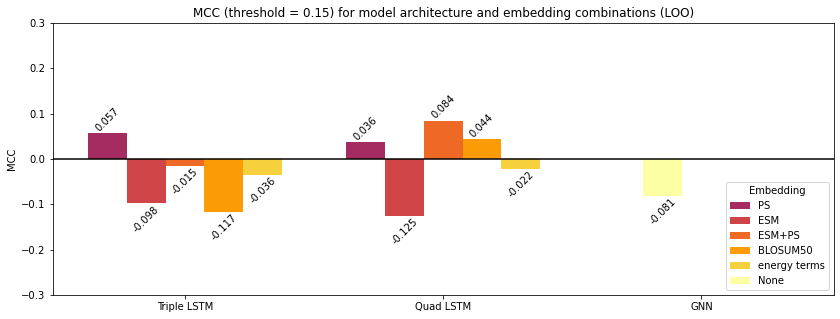

In [186]:
  from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_LOO_results_df

metric = "MCC (threshold = 0.15)"
embeddings = ["PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms", "Raw"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
model_list = ["Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb != "Raw" and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb == "Raw":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

model_list[-1]  = "GNN"
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
ps = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , rows[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, rows[4], width, color=my_cmap.colors[8])
raw = ax.bar(ind+width, rows[5], width, color=my_cmap.colors[9])

# add some text for labels, title and axes ticks
ax.set_ylabel('MCC')
ax.set_title('MCC (threshold = 0.15) for model architecture and embedding combinations (LOO)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width*2)
ax.set_xticklabels(model_list)
ax.set_ylim(-0.3,0.3)
ax.axhline(y=0, color='black', linestyle='-')
ax.legend((ps, esm, esm_ps, blosum, energy, raw), ('PS', "ESM", 'ESM+PS', "BLOSUM50",  "energy terms", "None"), loc="lower right", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)
        elif height < 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='top', rotation=45)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)
autolabel(raw)

plt.savefig("loo_results_mcc.png", dpi=300, bbox_inches = "tight")
plt.show()

In [204]:
unique_peptides_filt = unique_peptides[:-2]
sub_df = metadata[metadata["peptide"].str.contains('|'.join(unique_peptides_filt))]
sub_df['count'] = sub_df.groupby('peptide')['peptide'].transform("count")
sub_df = sub_df.sort_values('count', ascending=False)
sorted_pep = sub_df["peptide"].unique()

embeddings = ["PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms"]
model_list = ["Quad LSTM"]

pred_set = list()

df = individual_AUC_results_df
for emb in embeddings:
    pred_set.append(list())
    data = df[(df["Model"] == "Quad LSTM") & (df["Embedding"] == emb) & (df["Swapped negatives"] == 0)]
    for pep in sorted_pep:
        pred_set[-1].append(data[pep].values[0])

/tmp/ipykernel_165/260663147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['count'] = sub_df.groupby('peptide')['peptide'].transform("count")


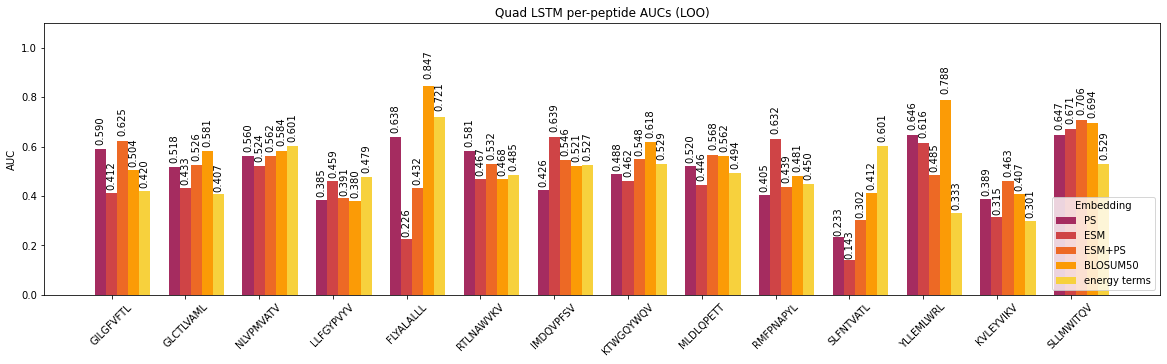

In [209]:
from matplotlib import cm

N = len(unique_peptides_filt)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(20, 5))
ps = ax.bar(ind, pred_set[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, pred_set[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , pred_set[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, pred_set[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, pred_set[4], width, color=my_cmap.colors[8])
#raw = ax.bar(ind+width, rows[3], width, color=my_cmap.colors[9])
# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('Quad LSTM per-peptide AUCs (LOO)')
ax.set_xticks(ind + width)
plt.xticks(rotation=45)
ax.set_xticklabels(sub_df["peptide"].unique())

ax.set_ylim(0,1.1)

ax.legend((ps, esm, esm_ps, blosum, energy), ('PS', "ESM", 'ESM+PS', "BLOSUM50", "energy terms"), loc="lower right", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.03*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom',
                    rotation=90.0)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)



plt.savefig("loo_per_peptide_perf.png", dpi=300, bbox_inches = "tight")
plt.show()

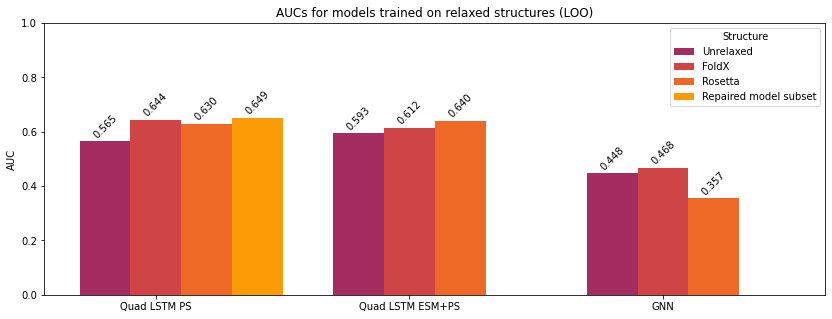

In [247]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_LOO_results_df

df2 = {'Model': "Quad LSTM", 
       'Embedding': "ESM+PS (repaired model subset)", 
       'Swapped negatives': 0 ,
       'AUC': 0.0, 
       'MCC (threshold = 0.15)':0.0,
       'F1 (threshold = 0.15)':0.0}
df3 = {'Model': "Modified ProteinSolver", 
       'Embedding': "Raw (repaired model subset)", 
       'Swapped negatives': 0,
       'AUC': 0.0, 
       'MCC (threshold = 0.15)':0.0,
       'F1 (threshold = 0.15)':0.0}

df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

metric = "AUC"
embeddings = ["PS", "PS (FoldX)", "PS (Rosetta)", "PS (repaired model subset)", "ESM+PS", "ESM+PS (FoldX)", "ESM+PS (Rosetta)", "ESM+PS (repaired model subset)", "Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"]
model_list = ["Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb not in ["Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"] and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb in ["Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"]:
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

ps_rows = [x[0] for x in rows[0:4]]
esm_ps_rows = [x[0] for x in rows[4:8]]
raw_rows = [x[1] for x in rows[8:]]
rows = [[ps_rows[i], esm_ps_rows[i], raw_rows[i]] for i in range(4)]

model_list = ["Quad LSTM PS", "Quad LSTM ESM+PS", "GNN"]
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.2
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
unrelaxed = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
foldx = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
rosetta = ax.bar(ind+width*2, rows[2], width, color=my_cmap.colors[6])
subset = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])

# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('AUCs for models trained on relaxed structures (LOO)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width)
ax.set_xticklabels(model_list)
ax.set_ylim(0,1)

ax.legend((unrelaxed, foldx, rosetta, subset), ('Unrelaxed', 'FoldX', "Rosetta", "Repaired model subset"), loc="upper right", title="Structure")
          
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(unrelaxed)
autolabel(foldx)
autolabel(rosetta)
autolabel(subset)


plt.savefig("loo_repair.png", dpi=300, bbox_inches = "tight")
plt.show()

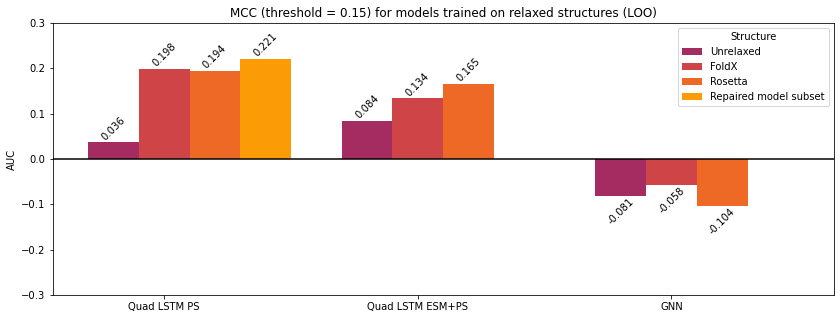

In [250]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_LOO_results_df

df2 = {'Model': "Quad LSTM", 
       'Embedding': "ESM+PS (repaired model subset)", 
       'Swapped negatives': 0 ,
       'AUC': 0.0, 
       'MCC (threshold = 0.15)':0.0,
       'F1 (threshold = 0.15)':0.0}
df3 = {'Model': "Modified ProteinSolver", 
       'Embedding': "Raw (repaired model subset)", 
       'Swapped negatives': 0,
       'AUC': 0.0, 
       'MCC (threshold = 0.15)':0.0,
       'F1 (threshold = 0.15)':0.0}

df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

metric = "MCC (threshold = 0.15)"
embeddings = ["PS", "PS (FoldX)", "PS (Rosetta)", "PS (repaired model subset)", "ESM+PS", "ESM+PS (FoldX)", "ESM+PS (Rosetta)", "ESM+PS (repaired model subset)", "Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"]
model_list = ["Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb not in ["Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"] and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb in ["Raw", "Raw (FoldX)", "Raw (Rosetta)", "Raw (repaired model subset)"]:
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

ps_rows = [x[0] for x in rows[0:4]]
esm_ps_rows = [x[0] for x in rows[4:8]]
raw_rows = [x[1] for x in rows[8:]]
rows = [[ps_rows[i], esm_ps_rows[i], raw_rows[i]] for i in range(4)]

model_list = ["Quad LSTM PS", "Quad LSTM ESM+PS", "GNN"]
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.2
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
unrelaxed = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
foldx = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
rosetta = ax.bar(ind+width*2, rows[2], width, color=my_cmap.colors[6])
subset = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])

# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('MCC (threshold = 0.15) for models trained on relaxed structures (LOO)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width)
ax.set_xticklabels(model_list)
ax.set_ylim(-0.3,0.3)
ax.axhline(y=0, color='black', linestyle='-')

ax.legend((unrelaxed, foldx, rosetta, subset), ('Unrelaxed', 'FoldX', "Rosetta", "Repaired model subset"), loc="upper right", title="Structure")
          

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)
        elif height < 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='top', rotation=45)

autolabel(unrelaxed)
autolabel(foldx)
autolabel(rosetta)
autolabel(subset)


plt.savefig("loo_repair_mcc.png", dpi=300, bbox_inches = "tight")
plt.show()

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalar

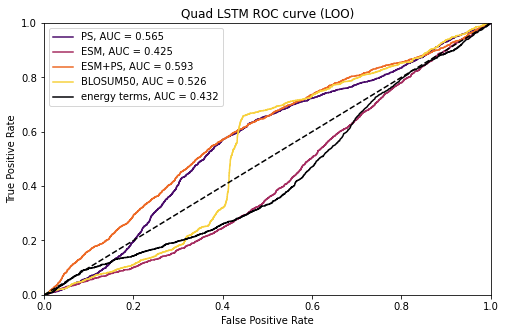

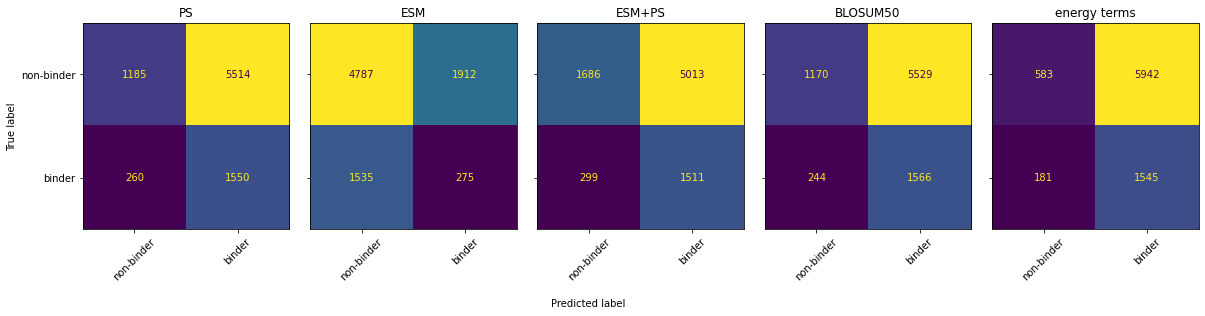

In [285]:
from matplotlib import cm


paths = [
    "lstm_ps_no_swapped/",
    "lstm_esm_no_swapped/",
    "lstm_esm_ps_no_swapped/",
    "lstm_blosum_no_swapped/",
    "lstm_energy_no_swapped/"
]

model_names = [
    "PS",
    "ESM",
    "ESM+PS",
    "BLOSUM50",
    "energy terms"
]

fprs = list()
tprs = list()
aucs = list()

for path in paths:
    save_dir = next(Path(out_dir / f"{path}").glob("*"))
    pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
    auc, overall_fpr, overall_tpr, _, _, _, _, _ = compute_auc_mcc_f1(pred_paths, 0.15)
    fprs.append(overall_fpr)
    tprs.append(overall_tpr)
    aucs.append(auc)

my_cmap = cm.get_cmap('inferno', 10)

fig = plt.figure(figsize=(8, 5))
color_arr = [2, 4, 6, 8, 0]
for i, model in enumerate(model_names):
    plt.plot(
        fprs[i], 
        tprs[i], 
        label=f"{model}, AUC = {round(aucs[i], 3)}",
        color=my_cmap.colors[color_arr[i]],
    )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Quad LSTM ROC curve (LOO)")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
plt.savefig("loo_quad_lstm_roc.png", dpi=300, bbox_inches = "tight")
plt.show()

f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

thresh_pred = 0.15

labels = ["non-binder", "binder"]

for i in range(len(model_names)):
    path = paths[i]
    model_name = model_names[i]
    save_dir = next(Path(out_dir / f"{path}").glob("*"))
    pred_paths = [save_dir / f"pred_{j}.pt" for j in range(len(unique_peptides))]
    overall_true = list()
    overall_thres_pred = list()
    for j in range(len(pred_paths)):
        data = torch.load(pred_paths[j])
        pred = data["y_pred"]
        true = data["y_true"]

        thresh_pred = torch.zeros(len(pred))
        thresh_pred[pred >= threshold] = 1

        overall_true.extend(true)
        overall_thres_pred.extend(thresh_pred)

    cf_matrix = confusion_matrix(overall_true, overall_thres_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.10, hspace=0.1)

plt.savefig("loo_cm.png", dpi=300, bbox_inches = "tight")
plt.show()



In [61]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

stat_df = overall_LOO_results_df.copy()

stat_df = stat_df[~stat_df["Embedding"].str.contains('|'.join(["FoldX", "Rosetta", "repaired model subset"]))]
stat_df = stat_df.rename(columns={"Swapped negatives":"Swapped_negatives"})

model = ols('AUC ~ C(Embedding)', data=stat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

#tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df['Model'], alpha=0.05)
#print(tukey)

tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df[['Embedding', "Model"]], alpha=0.05)
print(tukey)

#tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df['Swapped_negatives'], alpha=0.05)
#print(tukey)

                sum_sq    df         F   PR(>F)
C(Embedding)  0.027738   6.0  2.389932  0.08859
Residual      0.025147  13.0       NaN      NaN


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [296]:
individual_AUC_results_df

,Model,Embedding,Swapped negatives,NLVPMVATV,SLFNTVATL,KTWGQYWQV,RTLNAWVKV,KVLEYVIKV,YLLEMLWRL,IMDQVPFSV,MLDLQPETT,FLYALALLL,SLLMWITQV,LLFGYPVYV,GLCTLVAML,RMFPNAPYL,GILGFVFTL,KLQCVDLHV,KVAELVHFL
0,Single LSTM,PS (old),0,0.540930,0.363265,0.722078,0.417558,0.583333,0.080808,0.479167,0.369318,0.644099,0.647059,0.526933,0.610785,0.512821,0.569092,1.0,0.0
1,Single LSTM,energy terms,0,0.506093,0.819149,0.573003,0.440341,0.675926,0.541667,0.271978,0.565982,0.759749,0.505882,0.511588,0.549030,0.447293,0.546531,0.5,0.0
2,Single LSTM,BLOSUM50,0,0.466203,0.391837,0.501299,0.430036,0.555556,0.686869,0.662037,0.531250,0.214596,0.400000,0.456267,0.537752,0.544160,0.757813,0.25,0.0
3,Single LSTM,PS,0,0.515084,0.375510,0.615584,0.454100,0.805556,0.444444,0.615741,0.693182,0.484472,0.505882,0.472267,0.584067,0.458689,0.647131,0.5,0.0
4,Single LSTM,ESM,0,0.543663,0.473469,0.574026,0.433155,0.250000,0.646465,0.481481,0.471591,0.271739,0.800000,0.476000,0.387554,0.487179,0.646852,0.5,0.5
5,Single LSTM,ESM+PS,0,0.499848,0.306122,0.563636,0.448752,0.435185,0.616162,0.601852,0.437500,0.518634,0.552941,0.463200,0.497258,0.398860,0.687823,1.0,1.0
6,Quad LSTM,energy terms,1,0.557271,0.776596,0.443526,0.398674,0.328704,0.635417,0.535714,0.431085,0.610542,0.517647,0.545789,0.493461,0.438746,0.614860,1.0,0.0
7,Quad LSTM,energy terms,0,0.601393,0.601064,0.528926,0.485322,0.300926,0.333333,0.527473,0.494135,0.721084,0.529412,0.478519,0.406667,0.450142,0.419682,0.5,0.0
8,Quad LSTM,BLOSUM50,1,0.557899,0.502041,0.441558,0.427362,0.203704,0.414141,0.402778,0.502841,0.865217,0.576471,0.374667,0.603591,0.364672,0.442604,1.0,0.0
9,Quad LSTM,BLOSUM50,0,0.584089,0.412245,0.618182,0.467914,0.407407,0.787879,0.520833,0.562500,0.846894,0.694118,0.379733,0.581455,0.481481,0.503561,0.5,0.0


Quad LSTM PS (repaired model subset) (no swapped negatives) lstm_ps_repaired_model_subset_no_swapped


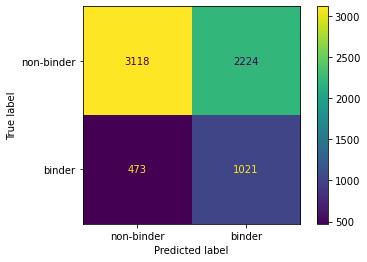

In [12]:
idx = 25
print(model_names[idx], paths[idx])
save_dir = next(Path(out_dir / f"{paths[idx]}").glob("*"))
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
plot_confusion_matrix(pred_paths, threshold, normalize=None)


In [36]:
t = ["/home/sebastian/masters/data/results_2/lstm_esm_ps_nested_loo/b3edafc0112356cefbdde3ca0ec5b396/pred_0.pt",
    "/home/sebastian/masters/data/results_2/lstm_esm_ps_nested_loo/b3edafc0112356cefbdde3ca0ec5b396/pred_1.pt"]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(t, threshold)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### 5 fold CV

In [5]:
overall_CV_results_df = pd.DataFrame(columns=[
    "Model",
    "Embedding",
    "Swapped negatives",
    "AUC",
    f"MCC (threshold = {threshold})",
    f"F1 (threshold = {threshold})"])

model_names = [
    ["Triple LSTM", "BLOSUM50", 1],
    ["Triple LSTM", "energy terms", 1],
    ["Triple LSTM", "ESM", 1],
    ["Triple LSTM", "ESM+PS", 1],
    ["Triple LSTM", "PS", 1],
    ["Triple LSTM", "BLOSUM50", 0],
    ["Triple LSTM", "energy terms", 0],
    ["Triple LSTM", "ESM", 0],
    ["Triple LSTM", "ESM+PS", 0],
    ["Triple LSTM", "PS", 0],
    ["Triple LSTM", "ESM+PS (Rosetta)", 0],
    ["Triple LSTM", "PS (Rosetta)", 0],
    ["Triple LSTM", "ESM+PS (FoldX)", 0],
    ["Triple LSTM", "PS (FoldX)", 0],
    ["Quad LSTM", "BLOSUM50", 1],
    ["Quad LSTM", "BLOSUM50", 0],
    ["Quad LSTM", "energy terms", 1],
    ["Quad LSTM", "energy terms", 0],
    ["Quad LSTM", "ESM", 1],
    ["Quad LSTM", "ESM",  0],
    ["Quad LSTM", "ESM+PS", 1],
    ["Quad LSTM", "ESM+PS", 0],
    ["Quad LSTM", "ESM+PS (FoldX)", 0],
    ["Quad LSTM", "ESM+PS (Rosetta)", 0],
    ["Quad LSTM", "PS", 1],
    ["Quad LSTM", "PS", 0],
    ["Quad LSTM", "PS (FoldX)", 0],
    ["Quad LSTM", "PS (Rosetta)", 0],
    ["Modified ProteinSolver", "Raw", 1],
    ["Modified ProteinSolver", "Raw", 0],
    ["Modified ProteinSolver",  "Raw (FoldX)", 0],
    ["Modified ProteinSolver",  "Raw (Rosetta)", 0],
    ["Single LSTM", "BLOSUM50", 1],
    ["Single LSTM","energy terms", 1],
    ["Single LSTM", "ESM", 1],
    ["Single LSTM", "ESM+PS", 1],
    ["Single LSTM", "PS", 1],
    ["Single LSTM", "BLOSUM50", 0],
    ["Single LSTM","energy terms", 0],
    ["Single LSTM", "ESM", 0],
    ["Single LSTM", "ESM+PS", 0],
    ["Single LSTM", "PS", 0]
]

paths = [
    "cdr_lstm_blosum_80_cv_cluster_cdr3b_low_cov/",
    "cdr_lstm_energy_80_cv_cluster_cdr3b_low_cov/",
    "cdr_lstm_esm_80_cv_cluster_cdr3b_low_cov/",
    "cdr_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/",
    "cdr_lstm_ps_80_cv_cluster_cdr3b_low_cov/",
    "cdr_lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_esm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_esm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "cdr_lstm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_blosum_80_cv_cluster_cdr3b_low_cov/",
    "lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_energy_80_cv_cluster_cdr3b_low_cov/",
    "lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_80_cv_cluster_cdr3b_low_cov/",
    "lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/",
    "lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_ps_80_cv_cluster_cdr3b_low_cov/",
    "lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "proteinsolver_finetune_80_cv_cluster_cdr3b_low_cov/",
    "proteinsolver_finetune_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "proteinsolver_finetune_80_cv_foldx_cluster_cdr3b_low_cov_no_swapped/",
    "proteinsolver_finetune_80_cv_rosetta_cluster_cdr3b_low_cov_no_swapped/",
    "single_lstm_blosum_80_cv_cluster_cdr3b_low_cov/",
    "single_lstm_energy_80_cv_cluster_cdr3b_low_cov/",
    "single_lstm_esm_80_cv_cluster_cdr3b_low_cov/",
    "single_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/",
    "single_lstm_ps_80_cv_cluster_cdr3b_low_cov/",
    "single_lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "single_lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "single_lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "single_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "single_lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
]


for model_name, path in zip(model_names, paths):
    print(model_name, path)
    try:
        save_dir = next(Path(out_dir / f"{path}").glob("*"))
        pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
        overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc, overall_f1, individual_f1 = compute_auc_mcc_f1(pred_paths, threshold)
        overall_row = model_name + [overall_auc, overall_mcc, overall_f1]
        overall_CV_results_df = overall_CV_results_df.append(
            pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
        )
    except IndexError:
        print(model_name, "failed!")

['Triple LSTM', 'BLOSUM50', 1] cdr_lstm_blosum_80_cv_cluster_cdr3b_low_cov/
['Triple LSTM', 'energy terms', 1] cdr_lstm_energy_80_cv_cluster_cdr3b_low_cov/


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Triple LSTM', 'ESM', 1] cdr_lstm_esm_80_cv_cluster_cdr3b_low_cov/
['Triple LSTM', 'ESM+PS', 1] cdr_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/
['Triple LSTM', 'PS', 1] cdr_lstm_ps_80_cv_cluster_cdr3b_low_cov/
['Triple LSTM', 'BLOSUM50', 0] cdr_lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'energy terms', 0] cdr_lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Triple LSTM', 'ESM', 0] cdr_lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'ESM+PS', 0] cdr_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'PS', 0] cdr_lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'ESM+PS (Rosetta)', 0] cdr_lstm_esm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'PS (Rosetta)', 0] cdr_lstm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'ESM+PS (FoldX)', 0] cdr_lstm_esm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Triple LSTM', 'PS (FoldX)', 0] cdr_lstm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'BLOSUM50', 1] lstm_blosum_80_cv_cluster_cdr3b_low_cov/
['Quad LSTM', 'BLOSUM50', 0] lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'energy terms', 1] lstm_energy_80_cv_cluster_cdr3b_low_cov/


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'energy terms', 0] lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Quad LSTM', 'ESM', 1] lstm_esm_80_cv_cluster_cdr3b_low_cov/
['Quad LSTM', 'ESM', 0] lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'ESM+PS', 1] lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/
['Quad LSTM', 'ESM+PS', 0] lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'ESM+PS (FoldX)', 0] lstm_esm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'ESM+PS (Rosetta)', 0] lstm_esm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'PS', 1] lstm_ps_80_cv_cluster_cdr3b_low_cov/
['Quad LSTM', 'PS', 0] lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'PS (FoldX)', 0] lstm_ps_foldx_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Quad LSTM', 'PS (Rosetta)', 0] lstm_ps_rosetta_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Modified ProteinSolver', 'Raw', 1] proteinsolver_finetune_80_cv_cluster_cdr3b_low_cov/
['Modified ProteinSolver', 'Raw', 0] proteinsolver_finetune_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Modified ProteinSolver', 'Raw (F

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


['Single LSTM', 'ESM', 1] single_lstm_esm_80_cv_cluster_cdr3b_low_cov/
['Single LSTM', 'ESM+PS', 1] single_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov/
['Single LSTM', 'PS', 1] single_lstm_ps_80_cv_cluster_cdr3b_low_cov/
['Single LSTM', 'BLOSUM50', 0] single_lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Single LSTM', 'energy terms', 0] single_lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Single LSTM', 'ESM', 0] single_lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Single LSTM', 'ESM+PS', 0] single_lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/
['Single LSTM', 'PS', 0] single_lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/


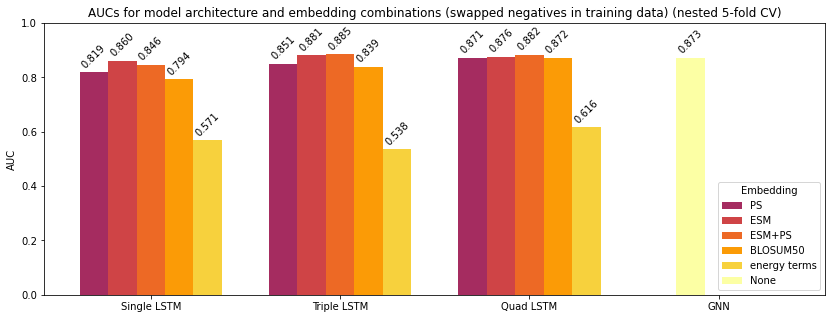

In [61]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_CV_results_df

metric = "AUC"
embeddings = ["PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms", "Raw"]
model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb != "Raw" and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 1)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb == "Raw":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 1)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

model_list[-1]  = "GNN"
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
ps = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , rows[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, rows[4], width, color=my_cmap.colors[8])
raw = ax.bar(ind+width, rows[5], width, color=my_cmap.colors[9])

# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('AUCs for model architecture and embedding combinations (swapped negatives in training data) (nested 5-fold CV)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width*2)
ax.set_xticklabels(model_list)
ax.set_ylim(0,1)

ax.legend((ps, esm, esm_ps, blosum, energy, raw), ('PS', "ESM", 'ESM+PS', "BLOSUM50",  "energy terms", "None"), loc="lower right", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)
autolabel(raw)

plt.savefig("cv_perf_swap_auc.png", dpi=300, bbox_inches = "tight")
plt.show()

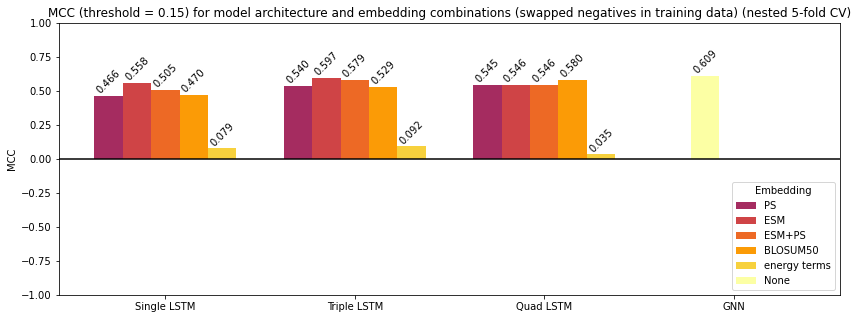

In [135]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_CV_results_df

metric = "MCC (threshold = 0.15)"
embeddings = ["PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms", "Raw"]
model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb != "Raw" and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 1)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb == "Raw":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 1)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

model_list[-1]  = "GNN"
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
ps = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , rows[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, rows[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, rows[4], width, color=my_cmap.colors[8])
raw = ax.bar(ind+width, rows[5], width, color=my_cmap.colors[9])

# add some text for labels, title and axes ticks
ax.set_ylabel('MCC')
ax.set_title('MCC (threshold = 0.15) for model architecture and embedding combinations (swapped negatives in training data) (nested 5-fold CV)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width*2)
ax.set_xticklabels(model_list)
ax.set_ylim(-1,1)
ax.axhline(y=0, color='black', linestyle='-')
ax.legend((ps, esm, esm_ps, blosum, energy, raw), ('PS', "ESM", 'ESM+PS', "BLOSUM50",  "energy terms", "None"), loc="lower right", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)
autolabel(raw)

plt.savefig("cv_perf_swap_mcc.png", dpi=300, bbox_inches = "tight")
plt.show()

In [12]:
model_sub_dir = data_root / "raw" / "energy_terms_mock"

paths = list(model_sub_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata_energy = pd.read_csv(metadata_path)
metadata_energy = metadata_energy.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata_energy = metadata_energy.reset_index(drop=True)
id_map = {k: v for k, v in zip(metadata_energy["#ID"], metadata_energy.index)}

In [164]:
cluster_path = data_root / "clusterRes_cdr3b_80_raw_idx_low_cov_cluster.tsv"
cv_fold = 5
unique_peptides_filt = unique_peptides[:-2]

pred_set = list()

model_paths = [
    "lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
  #  "lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/",
]

model_names = [
    ["Quad LSTM", "PS"],
    ["Quad LSTM", "ESM"],
    ["Quad LSTM", "ESM+PS"],
 #   ["Quad LSTM", "energy terms"],
    ["Quad LSTM", "BLOSUM50"],
]

abundance_corr = list()
for path in model_paths:
    save_dir = next(Path(out_dir / f"{path}").glob("*"))
    pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
    n_splits = 5
    partitions = partition_clusters(metadata, cluster_path, n_splits)

    y_pred_all = list()
    y_true_all = list()
    pep_list_all = list()

    for i in range(n_splits):
        test_idx = partitions[i]
        filtered_indices = list(metadata[metadata["origin"] == "swapped"].index)
        for k in range(n_splits):
            test_idx = [k for k in test_idx if k not in filtered_indices]

        data = torch.load(pred_paths[i])
        y_pred = data["y_pred"]
        y_true = data["y_true"]
        pep_list = metadata.iloc[test_idx]["peptide"]

        y_pred_all.extend(y_pred)
        y_true_all.extend(y_true)
        pep_list_all.extend(pep_list)

    sub_df = pd.DataFrame({"peptide": pep_list_all, "y_pred": y_pred_all, "y_true": y_true_all})

    sub_df = sub_df[sub_df["peptide"].str.contains('|'.join(unique_peptides_filt))]
    sub_df['count'] = sub_df.groupby('peptide')['peptide'].transform("count")
    sub_df = sub_df.sort_values('count', ascending=False)
    
    individual_auc = list()
    for pep in sub_df["peptide"].unique():  
        pep_df = sub_df[sub_df["peptide"] == pep]
        auc = roc_auc_score(list(pep_df["y_true"]), list(pep_df["y_pred"]))
        individual_auc.append(auc)
    pred_set.append(individual_auc)
    abundance_corr.append([individual_auc, list(sub_df["count"].unique())])

save_dir = next(Path(out_dir / "lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped").glob("*"))
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
partitions = partition_clusters(metadata_energy, cluster_path, n_splits)

y_pred_all = list()
y_true_all = list()
pep_list_all = list()

for i in range(n_splits):
    test_idx = partitions[i]
    filtered_indices = list(metadata_energy[metadata_energy["origin"] == "swapped"].index)
    for k in range(n_splits):
        test_idx = [k for k in test_idx if k not in filtered_indices]

    data = torch.load(pred_paths[i])
    y_pred = data["y_pred"]
    y_true = data["y_true"]
    pep_list = metadata_energy.iloc[test_idx]["peptide"]

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)
    pep_list_all.extend(pep_list)

sub_df = pd.DataFrame({"peptide": pep_list_all, "y_pred": y_pred_all, "y_true": y_true_all})

sub_df = sub_df[sub_df["peptide"].str.contains('|'.join(unique_peptides_filt))]
sub_df['count'] = sub_df.groupby('peptide')['peptide'].transform("count")
sub_df = sub_df.sort_values('count', ascending=False)

individual_auc = list()
for pep in sub_df["peptide"].unique():  
    pep_df = sub_df[sub_df["peptide"] == pep]
    auc = roc_auc_score(list(pep_df["y_true"]), list(pep_df["y_pred"]))
    individual_auc.append(auc)
pred_set.append(individual_auc)
abundance_corr.append([individual_auc, list(sub_df["count"].unique())])

In [165]:
from scipy.stats import linregress

counts = list()
aucs = list()
for i in range(len(abundance_corr)):
    counts.extend(abundance_corr[i][1])
    aucs.extend(abundance_corr[i][0])
    

ln = linregress(
   np.log(counts), 
   aucs
)
ln

LinregressResult(slope=0.07763656699155089, intercept=0.16668560131147325, rvalue=0.6469805786258819, pvalue=1.437209715478768e-09, stderr=0.011095941569198584, intercept_stderr=0.055596408931554396)

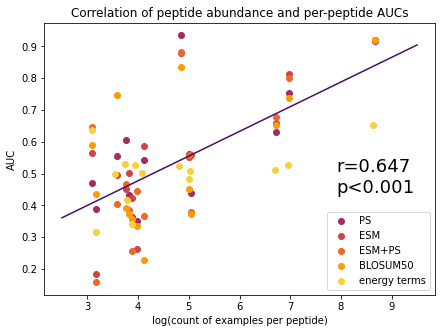

In [168]:
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(len(abundance_corr)):
    plt.scatter(np.log(abundance_corr[i][1]), abundance_corr[i][0], color=my_cmap.colors[i+4])


plt.legend(("PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms"))


x_vals = np.array([2.5, 9.5])
y_vals = ln.intercept + ln.slope * x_vals
plt.plot(x_vals, y_vals, '-', color=my_cmap.colors[2])

plt.title("Correlation of peptide abundance and per-peptide AUCs")
plt.ylabel("AUC")
plt.xlabel("log(count of examples per peptide)")
plt.text(7.9, 0.44, f"r={round(ln.rvalue, 3)}\np<0.001", fontsize=18)

plt.savefig("corr_num_pep.png", dpi=300, bbox_inches = "tight")

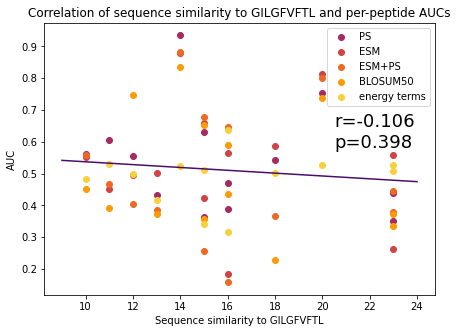

In [169]:
import Bio
from Bio.Align import substitution_matrices

align_score = list()
aligner = Bio.Align.PairwiseAligner(mode="global")
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
for pep in sorted_pep:
    alignment = aligner.align("GILGFVFTL", pep)
    #data_row.append(alignment.score/list(alignment)[0].shape[1])

    align_score.append(alignment.score)

from scipy.stats import linregress

scores = list()
aucs = list()
for i in range(len(abundance_corr)):
    scores.extend(align_score[1:])
    aucs.extend(abundance_corr[i][0][1:])
    

ln = linregress(
   scores, 
   aucs
)

fig, ax = plt.subplots(figsize=(7, 5))
for i in range(len(abundance_corr)):
    plt.scatter(align_score[1:], abundance_corr[i][0][1:], color=my_cmap.colors[i+4])


plt.legend(("PS", "ESM", "ESM+PS", "BLOSUM50", "energy terms"))


x_vals = np.array([9, 24])
y_vals = ln.intercept + ln.slope * x_vals
plt.plot(x_vals, y_vals, '-', color=my_cmap.colors[2])

plt.title("Correlation of sequence similarity to GILGFVFTL and per-peptide AUCs")
plt.ylabel("AUC")
plt.xlabel("Sequence similarity to GILGFVFTL")
plt.text(20.5, 0.58, f"r={round(ln.rvalue, 3)}\np=0.398", fontsize=18)

plt.savefig("sequence_sim_pep.png", dpi=300, bbox_inches = "tight")

In [145]:
ln

LinregressResult(slope=-0.004463931267906433, intercept=0.5815186560925172, rvalue=-0.10649739206922382, pvalue=0.398471311760483, stderr=0.005250871146612934, intercept_stderr=0.08583701212244149)

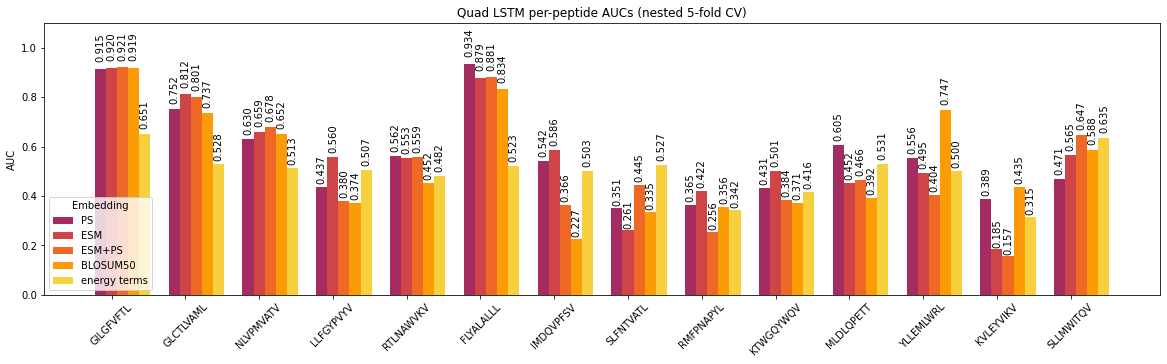

In [106]:
from matplotlib import cm

N = len(unique_peptides_filt)
ind = np.arange(N)  # the x locations for the groups
width = 0.15
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(20, 5))
ps = ax.bar(ind, pred_set[0], width, color=my_cmap.colors[4])
esm = ax.bar(ind+width, pred_set[1], width, color=my_cmap.colors[5])
esm_ps = ax.bar(ind+width*2 , pred_set[2], width, color=my_cmap.colors[6])
blosum = ax.bar(ind+width*3, pred_set[3], width, color=my_cmap.colors[7])
energy = ax.bar(ind+width*4, pred_set[4], width, color=my_cmap.colors[8])
#raw = ax.bar(ind+width, rows[3], width, color=my_cmap.colors[9])
# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('Quad LSTM per-peptide AUCs (nested 5-fold CV)')
ax.set_xticks(ind + width)
plt.xticks(rotation=45)
ax.set_xticklabels(sub_df["peptide"].unique())

ax.set_ylim(0,1.1)

ax.legend((ps, esm, esm_ps, blosum, energy), ('PS', "ESM", 'ESM+PS', "BLOSUM50", "energy terms"), loc="lower left", title="Embedding")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.03*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom',
                    rotation=90.0)

autolabel(ps)
autolabel(esm_ps)
autolabel(esm)
autolabel(blosum)
autolabel(energy)



plt.savefig("per_peptide_perf.png", dpi=300, bbox_inches = "tight")
plt.show()

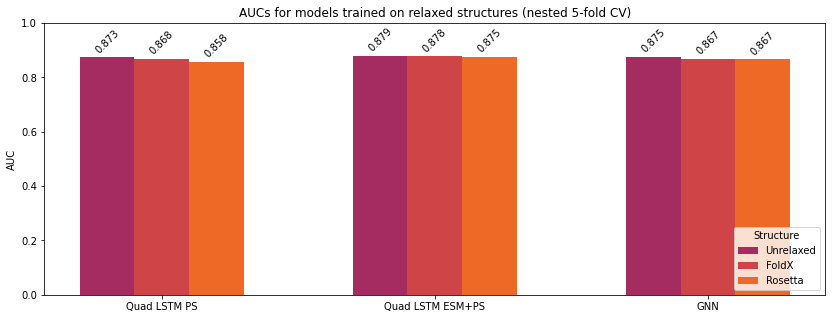

In [136]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_CV_results_df

metric = "AUC"
embeddings = ["PS", "PS (FoldX)", "PS (Rosetta)", "ESM+PS", "ESM+PS (FoldX)", "ESM+PS (Rosetta)", "Raw", "Raw (FoldX)", "Raw (Rosetta)"]
model_list = ["Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb not in ["Raw", "Raw (FoldX)", "Raw (Rosetta)"] and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb in ["Raw", "Raw (FoldX)", "Raw (Rosetta)"]:
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

ps_rows = [x[0] for x in rows[0:3]]
esm_ps_rows = [x[0] for x in rows[3:6]]
raw_rows = [x[1] for x in rows[6:]]
rows = [[ps_rows[i], esm_ps_rows[i], raw_rows[i]] for i in range(3)]

model_list = ["Quad LSTM PS", "Quad LSTM ESM+PS", "GNN"]
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.2
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
unrelaxed = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
foldx = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
rosetta = ax.bar(ind+width*2, rows[2], width, color=my_cmap.colors[6])

#esm_ps = ax.bar(ind+width*3 , rows[3], width, color=my_cmap.colors[6], edgecolor="black")
#esm_ps_f = ax.bar(ind+width*4 , rows[4], width, color=my_cmap.colors[6], hatch="/", edgecolor="black")
#esm_ps_r = ax.bar(ind+width*5 , rows[5], width, color=my_cmap.colors[6], hatch=".", edgecolor="black")

#raw = ax.bar(ind, rows[6], width, color=my_cmap.colors[9], edgecolor="black")
#raw_f = ax.bar(ind+width, rows[7], width, color=my_cmap.colors[9], hatch="/", edgecolor="black")
#raw_r = ax.bar(ind+width*2, rows[8], width, color=my_cmap.colors[9], hatch=".", edgecolor="black")

# add some text for labels, title and axes ticks
ax.set_ylabel('AUC')
ax.set_title('AUCs for models trained on relaxed structures (nested 5-fold CV)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width)
ax.set_xticklabels(model_list)
ax.set_ylim(0,1)

ax.legend((unrelaxed, foldx, rosetta), ('Unrelaxed', 'FoldX', "Rosetta"), loc="lower right", title="Structure")
          
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(unrelaxed)
autolabel(foldx)
autolabel(rosetta)

plt.savefig("cv_repair.png", dpi=300, bbox_inches = "tight")
plt.show()

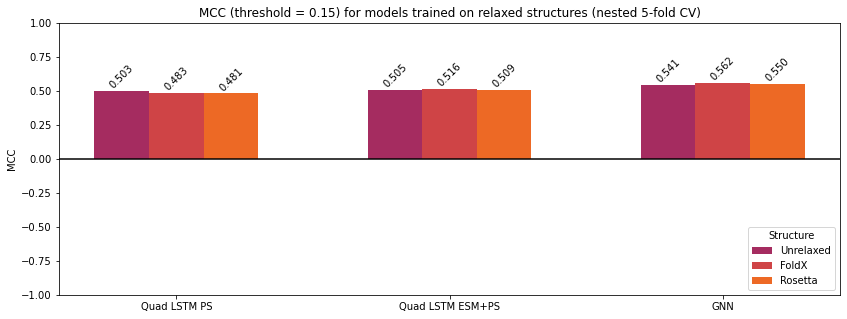

In [137]:
from matplotlib import cm

#metric = "AUC"
#embeddings = ["BLOSUM50", "energy terms", "ESM", "PS", "ESM+PS"]
#model_list = ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]

     # the width of the bars

df = overall_CV_results_df

metric = "MCC (threshold = 0.15)"
embeddings = ["PS", "PS (FoldX)", "PS (Rosetta)", "ESM+PS", "ESM+PS (FoldX)", "ESM+PS (Rosetta)", "Raw", "Raw (FoldX)", "Raw (Rosetta)"]
model_list = ["Quad LSTM", "Modified ProteinSolver"]
rows = list()
for emb in embeddings:
    row = list()
    for model in model_list:
        if emb not in ["Raw", "Raw (FoldX)", "Raw (Rosetta)"] and model != "Modified ProteinSolver":
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        elif model == "Modified ProteinSolver" and emb in ["Raw", "Raw (FoldX)", "Raw (Rosetta)"]:
            data = df[(df["Embedding"] == emb) & (df["Model"] == model) & (df["Swapped negatives"] == 0)][metric].values[0]
            row.append(data)
        else:
            row.append(0.0)
    rows.append(row)

ps_rows = [x[0] for x in rows[0:3]]
esm_ps_rows = [x[0] for x in rows[3:6]]
raw_rows = [x[1] for x in rows[6:]]
rows = [[ps_rows[i], esm_ps_rows[i], raw_rows[i]] for i in range(3)]

model_list = ["Quad LSTM PS", "Quad LSTM ESM+PS", "GNN"]
N = len(model_list)
ind = np.arange(N)  # the x locations for the groups
width = 0.2
my_cmap = cm.get_cmap('inferno', 10)

fig, ax = plt.subplots(figsize=(14, 5))
unrelaxed = ax.bar(ind, rows[0], width, color=my_cmap.colors[4])
foldx = ax.bar(ind+width, rows[1], width, color=my_cmap.colors[5])
rosetta = ax.bar(ind+width*2, rows[2], width, color=my_cmap.colors[6])

#esm_ps = ax.bar(ind+width*3 , rows[3], width, color=my_cmap.colors[6], edgecolor="black")
#esm_ps_f = ax.bar(ind+width*4 , rows[4], width, color=my_cmap.colors[6], hatch="/", edgecolor="black")
#esm_ps_r = ax.bar(ind+width*5 , rows[5], width, color=my_cmap.colors[6], hatch=".", edgecolor="black")

#raw = ax.bar(ind, rows[6], width, color=my_cmap.colors[9], edgecolor="black")
#raw_f = ax.bar(ind+width, rows[7], width, color=my_cmap.colors[9], hatch="/", edgecolor="black")
#raw_r = ax.bar(ind+width*2, rows[8], width, color=my_cmap.colors[9], hatch=".", edgecolor="black")

# add some text for labels, title and axes ticks
ax.set_ylabel('MCC')
ax.set_title('MCC (threshold = 0.15) for models trained on relaxed structures (nested 5-fold CV)')
#ax.set_title('AUCs for model architecture and embedding combinations (nested 5-fold CV)')

ax.set_xticks(ind + width)
ax.set_xticklabels(model_list)
ax.set_ylim(-1,1)
ax.axhline(y=0, color='black', linestyle='-')


ax.legend((unrelaxed, foldx, rosetta), ('Unrelaxed', 'FoldX', "Rosetta"), loc="lower right", title="Structure")
    
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.3f' % float(height),
                    ha='center', va='bottom', rotation=45)

autolabel(unrelaxed)
autolabel(foldx)
autolabel(rosetta)

plt.savefig("cv_repair_mcc.png", dpi=300, bbox_inches = "tight")
plt.show()

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


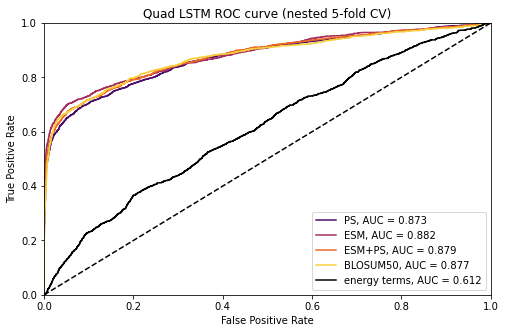

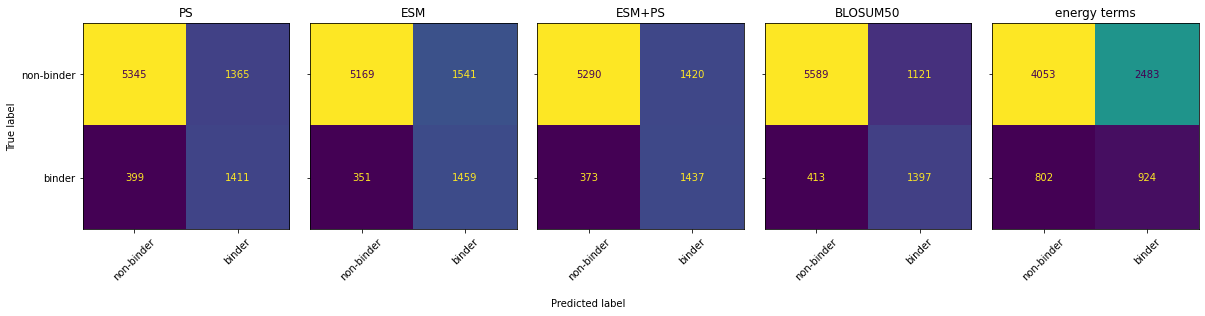

In [279]:
from matplotlib import cm


paths = [
    "lstm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_esm_ps_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_blosum_80_cv_cluster_cdr3b_low_cov_no_swapped/",
    "lstm_energy_80_cv_cluster_cdr3b_low_cov_no_swapped/"


]

model_names = [
    "PS",
    "ESM",
    "ESM+PS",
    "BLOSUM50",
    "energy terms"
]

fprs = list()
tprs = list()
aucs = list()

for path in paths:
    save_dir = next(Path(out_dir / f"{path}").glob("*"))
    pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
    auc, overall_fpr, overall_tpr, _, _, _, _, _ = compute_auc_mcc_f1(pred_paths, 0.15)
    fprs.append(overall_fpr)
    tprs.append(overall_tpr)
    aucs.append(auc)

my_cmap = cm.get_cmap('inferno', 10)

fig = plt.figure(figsize=(8, 5))
color_arr = [2, 4, 6, 8, 0]
for i, model in enumerate(model_names):
    plt.plot(
        fprs[i], 
        tprs[i], 
        label=f"{model}, AUC = {round(aucs[i], 3)}",
        color=my_cmap.colors[color_arr[i]],
    )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Quad LSTM ROC curve (nested 5-fold CV)")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
plt.savefig("cv_quad_lstm_roc.png", dpi=300, bbox_inches = "tight")
plt.show()


f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

thresh_pred = 0.15

labels = ["non-binder", "binder"]
#for i in range(len(pred_paths)):
#    data = torch.load(pred_paths[i])
#    pred = data["y_pred"]
#    true = data["y_true"]
#
#    thresh_pred = torch.zeros(len(pred))
#    thresh_pred[pred >= threshold] = 1
#
#    overall_true.extend(true)
#    overall_thres_pred.extend(thresh_pred)
#
#cm = confusion_matrix(overall_true, overall_thres_pred, normalize=None)
#disp = ConfusionMatrixDisplay(cm, display_labels=labels)
#plot = disp.plot(cmap="inferno", colorbar=False)
#plt.savefig("cv_quad_lstm_cm.png", dpi=300, bbox_inches = "tight")
#plt.title("Quad LSTM ESM+PS")
#plot.figure_.show()

for i in range(len(model_names)):
    path = paths[i]
    model_name = model_names[i]
    save_dir = next(Path(out_dir / f"{path}").glob("*"))
    pred_paths = [save_dir / f"pred_{j}.pt" for j in range(cv_fold)]
    overall_true = list()
    overall_thres_pred = list()
    for j in range(len(pred_paths)):
        data = torch.load(pred_paths[j])
        pred = data["y_pred"]
        true = data["y_true"]

        thresh_pred = torch.zeros(len(pred))
        thresh_pred[pred >= threshold] = 1

        overall_true.extend(true)
        overall_thres_pred.extend(thresh_pred)

    cf_matrix = confusion_matrix(overall_true, overall_thres_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(model_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.10, hspace=0.1)

plt.savefig("cv_cm.png", dpi=300, bbox_inches = "tight")
plt.show()



In [83]:
overall_CV_results_df

,Model,Embedding,Swapped negatives,AUC,MCC (threshold = 0.15),F1 (threshold = 0.15)
0,Triple LSTM,BLOSUM50,1,0.839493,0.528998,0.634669
1,Triple LSTM,energy terms,1,0.537932,0.091848,0.346763
2,Triple LSTM,ESM,1,0.880718,0.597489,0.687500
3,Triple LSTM,ESM+PS,1,0.884766,0.578742,0.673415
4,Triple LSTM,PS,1,0.850961,0.539774,0.643111
5,Triple LSTM,BLOSUM50,0,0.850358,0.491669,0.608398
6,Triple LSTM,energy terms,0,0.568156,0.133844,0.341901
7,Triple LSTM,ESM,0,0.879563,0.523471,0.630831
8,Triple LSTM,ESM+PS,0,0.874954,0.542515,0.645695
9,Triple LSTM,PS,0,0.863919,0.500250,0.614350


In [16]:
overall_CV_results_df.sort_values(by="AUC", ascending=False)

,Model,Embedding,Swapped negatives,AUC,MCC (threshold = 0.15),F1 (threshold = 0.15)
10,Triple LSTM,ESM+PS (Rosetta),0,0.999437,0.981529,0.985507
12,Triple LSTM,ESM+PS (FoldX),0,0.998290,0.979393,0.983849
11,Triple LSTM,PS (Rosetta),0,0.997643,0.965295,0.972864
13,Triple LSTM,PS (FoldX),0,0.997318,0.963636,0.971581
3,Triple LSTM,ESM+PS,1,0.884766,0.578742,0.673415
19,Quad LSTM,ESM,0,0.882334,0.493639,0.606653
20,Quad LSTM,ESM+PS,1,0.882171,0.546068,0.647722
2,Triple LSTM,ESM,1,0.880718,0.597489,0.687500
7,Triple LSTM,ESM,0,0.879563,0.523471,0.630831
21,Quad LSTM,ESM+PS,0,0.878870,0.504507,0.615813


In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

stat_df = overall_CV_results_df.copy()

stat_df = stat_df[~stat_df["Embedding"].str.contains('|'.join(["FoldX", "Rosetta"]))]
stat_df = stat_df.rename(columns={"Swapped negatives":"Swapped_negatives"})

model = ols('AUC ~ C(Model) + C(Embedding) + C(Swapped_negatives)', data=stat_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df['Model'], alpha=0.05)
print(tukey)

tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df['Embedding'], alpha=0.05)
print(tukey)

tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=stat_df['AUC'], groups=stat_df['Swapped_negatives'], alpha=0.05)
print(tukey)

                        sum_sq    df           F        PR(>F)
C(Model)              0.506751   3.0  654.855218  1.471131e-18
C(Embedding)          0.461864   5.0  358.109399  2.332113e-17
C(Swapped_negatives)  0.000116   1.0    0.450670  5.105412e-01
Residual              0.004643  18.0         NaN           NaN
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
        group1            group2   meandiff p-adj   lower  upper  reject
------------------------------------------------------------------------
Modified ProteinSolver   Quad LSTM  -0.0497    0.9 -0.3045 0.2052  False
Modified ProteinSolver Single LSTM  -0.0959 0.7496 -0.3712 0.1793  False
Modified ProteinSolver Triple LSTM  -0.0708 0.8567 -0.3257  0.184  False
             Quad LSTM Single LSTM  -0.0463 0.8889 -0.2265  0.134  False
             Quad LSTM Triple LSTM  -0.0211    0.9 -0.1683  0.126  False
           Single LSTM Triple LSTM   0.0251    0.9 -0.1551 0.2053  False
----------------------------

In [125]:
swap = list()
no_swap = list()
for model in ["Single LSTM", "Triple LSTM", "Quad LSTM", "Modified ProteinSolver"]:  # doesnt work
    for emb in ["PS", "ESM+PS", "ESM", "BLOSUM50", "energy terms"]:
        try:
            d_swap = overall_CV_results_df[
                (overall_CV_results_df["Model"] == model) & 
                (overall_CV_results_df["Embedding"] == emb) &
                (overall_CV_results_df["Swapped negatives"] == 0)]["AUC"].values[0]
            d_no_swap = overall_CV_results_df[
                (overall_CV_results_df["Model"] == model) & 
                (overall_CV_results_df["Embedding"] == emb) &
                (overall_CV_results_df["Swapped negatives"] == 1)]["AUC"].values[0]

            swap.append(d_swap)
            no_swap.append(d_no_swap)
        except:
            pass
    for i in range(len(swap)):
        print(swap[i], no_swap[i])

0.8639194819309846 0.8509606754987609
0.8749538908695688 0.8847664901894592
0.8795629101448319 0.8807177791866678
0.8503583338136368 0.8394928407341232
0.5681556360990595 0.5379321727882723
0.8639194819309846 0.8509606754987609
0.8749538908695688 0.8847664901894592
0.8795629101448319 0.8807177791866678
0.8503583338136368 0.8394928407341232
0.5681556360990595 0.5379321727882723
0.8731482243867897 0.8711814684682173
0.878870285135569 0.8821712048480457
0.8823339042082816 0.8763612074005154
0.8771682818585274 0.8722088743608533
0.6121471720578495 0.6164967340168579
0.8639194819309846 0.8509606754987609
0.8749538908695688 0.8847664901894592
0.8795629101448319 0.8807177791866678
0.8503583338136368 0.8394928407341232
0.5681556360990595 0.5379321727882723
0.8731482243867897 0.8711814684682173
0.878870285135569 0.8821712048480457
0.8823339042082816 0.8763612074005154
0.8771682818585274 0.8722088743608533
0.6121471720578495 0.6164967340168579


In [126]:
from scipy.stats import ttest_rel
#ttost_paired(np.array(swap), np.array(no_swap), low=-0.01, upp=0.01)
ttest_rel(no_swap, swap, alternative="two-sided")

Ttest_relResult(statistic=-1.3476412279046766, pvalue=0.21071540890486146)

In [127]:
np.mean(swap), np.mean(no_swap)

(0.8160618120505099, 0.8112289447491774)

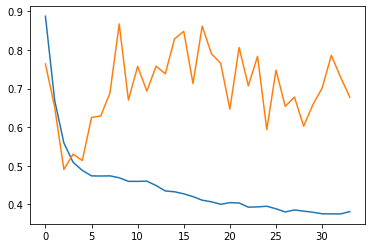

In [322]:
j = 2
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_3/single_lstm_blosum_no_swapped/995094ddf72c80f237f6089c0b32daf9//")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[j])
plt.plot(t["train"])
plt.plot(t["valid"])

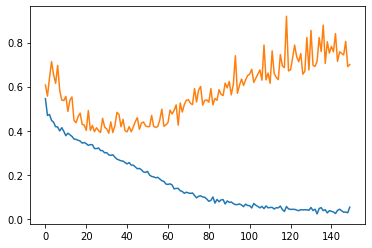

In [323]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_3/lstm_ps_single_no_swapped/995094ddf72c80f237f6089c0b32daf9//")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[j])
plt.plot(t["train"])
plt.plot(t["valid"])

In [315]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_single_foldx_no_swapped/bc38a2d1a44520efe7c92ab701554875//")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[3])
plt.plot(t["train"])
plt.plot(t["valid"])

FileNotFoundError: [Errno 2] No such file or directory: '/home/sebastian/masters/data/results_2/lstm_ps_single_foldx_no_swapped/bc38a2d1a44520efe7c92ab701554875/loss_3.pt'

In [17]:
t = 5e-5

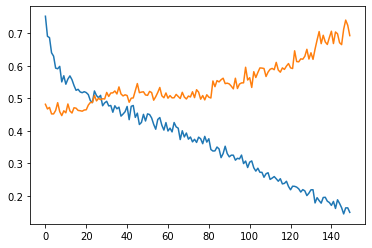

In [37]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_foldx_no_swapped/1a74acd389cb2982398cf6aa68b84998")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[13])
plt.plot(t["train"])
plt.plot(t["valid"])

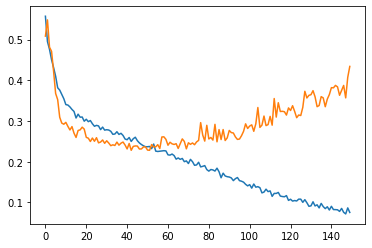

In [24]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_80_cv_cluster_cdr3b_low_cov/b3edafc0112356cefbdde3ca0ec5b396")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(cv_fold)]
t = torch.load(loss_paths[1])
plt.plot(t["train"])
plt.plot(t["valid"])